In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
# Note: process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# save the processed data
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

In [2]:
# load your data here if kodaira symbol has been processed
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

Loaded the dataset with 118 features and 3064705 curves..


## Features are:
- first 100 $a_p$
- 'rank'
- 'torsion'
- 'adelic_level': could get large as conductor gets bigger
- 'adelic_index'
- 'adelic_genus' 
- 'real_period'
- 'special_value'
- 'tamagawa_product': could get large as conductor gets bigger
- processed kodaira symbols: 'kodaira_-5.0', 'kodaira_-4.0', 'kodaira_-3.0', 'kodaira_-2.0', 'kodaira_-1.0', 'kodaira_2.0', 'kodaira_3.0', 'kodaira_4.0', 'kodaira_5.0', where 'kodaira_*' is an indicator of *normalized kodaira symbols*
    - *normalized kodaira symbols* converts Kodaira symbol $ks$ as follows:
        - If $ks$ is greater than or equal to 5, it is converted to 5. This represents the Kodaira symbol which indicates multiplicative reduction.
        - If $ks$ is less than or equal to -5, it is converted to -5. This represents the Kodaira symbol which indicates potential multiplicative reduction.
        - If $ks$ is between -4 and 4 (inclusive), it is left unchanged. These values represent potential good reduction.
    - example: if the list of Kodaira symbols PARI encoding for the bad primes is [4, 7], then 'kodaira_4.0' = 1, 'kodaira_5.0' = 1, and all other 'kodaira_*' are 0.

In [10]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df[df['sha'] == 9].shape[0]

df_balanced = df[df['sha'] == 4].sample(len_9) 
# df_balanced = df[df['sha'] == 4].iloc[:len_9]

df_balanced = pd.concat([df_balanced, df[df['sha'] == 9]])
df_balanced.drop('lmfdb_label', axis=1, inplace=True)

# rename 4 to 0 and 9 to 1
df_balanced['sha'] = df_balanced['sha'].replace({4: 0, 9: 1})

In [4]:
# drop conductor and adelic_level
df_balanced.drop(columns=['conductor','adelic_level'], axis=1, inplace=True)

# all features

## logistic regression

In [5]:
# split the data into training and testing
X = df_balanced.drop('sha', axis=1)
y = df_balanced['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.6918500892325996


## NN

In [28]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
hidden_units = [32,16,8]
# hidden_units = [16,8,4]
# hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 116 and the output dimension is 2.
Device: cpu.
The model has 4,538 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=116, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [29]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 50
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/50, Training accuracy_score: 0.6651132814436568, Validation accuracy_score: 0.6668980219126469
Epoch 2/50, Training accuracy_score: 0.7434105068332424, Validation accuracy_score: 0.7411630558722919
Epoch 3/50, Training accuracy_score: 0.8020590616892238, Validation accuracy_score: 0.7990183927420554
Epoch 4/50, Training accuracy_score: 0.7960272999190257, Validation accuracy_score: 0.7953993356799366
Epoch 5/50, Training accuracy_score: 0.8424966536116206, Validation accuracy_score: 0.839621238411581
Epoch 6/50, Training accuracy_score: 0.8416042833771256, Validation accuracy_score: 0.8352089633632442
Epoch 7/50, Training accuracy_score: 0.762133756382926, Validation accuracy_score: 0.7630757027415597
Epoch 8/50, Training accuracy_score: 0.7622824847553419, Validation accuracy_score: 0.7613901145208467
Epoch 9/50, Training accuracy_score: 0.8877431295754631, Validation accuracy_score: 0.8830499231570076
Epoch 10/50, Training accuracy_score: 0.8735478326971065, Validation accura

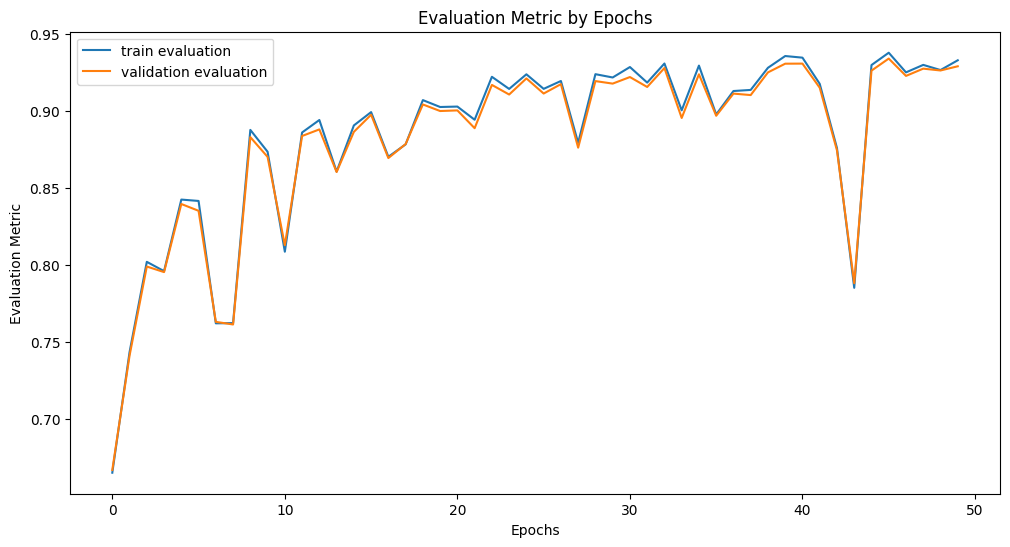

In [30]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [31]:
# print test accuracy, precision, recall
acc = executor.test(model, test_dataset, evaluator, if_regression = False)
prec = executor.test(model, test_dataset, precision_score, if_regression = False)
recall = executor.test(model, test_dataset, recall_score, if_regression = False)
print(f"Test accuracy : {acc:0.4f}, precision : {prec:0.4f}, recall : {recall:0.4f}")

0.9328772556018243

# just $a_p$

In [9]:
df_balanced_ap = df_balanced[list(df_balanced.columns[:100])+['sha']]

$# logistic regression

In [10]:
# split the data into training and testing
X = df_balanced_ap.drop('sha', axis=1)
y = df_balanced_ap['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.5947352766210589


## NN

In [7]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
hidden_units = [32,16,8]
# hidden_units = [16,8,4]
# hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced_ap, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 100 and the output dimension is 2.
Device: cpu.
The model has 4,026 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [8]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 100
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/100, Training accuracy_score: 0.5223670946738718, Validation accuracy_score: 0.514996777551931
Epoch 2/100, Training accuracy_score: 0.5838745393551799, Validation accuracy_score: 0.5768182043527837
Epoch 3/100, Training accuracy_score: 0.5899228265000909, Validation accuracy_score: 0.5817758167666451
Epoch 4/100, Training accuracy_score: 0.5923024804587445, Validation accuracy_score: 0.5863368201873977
Epoch 5/100, Training accuracy_score: 0.596202468890982, Validation accuracy_score: 0.5902533339943483
Epoch 6/100, Training accuracy_score: 0.6006808454381704, Validation accuracy_score: 0.5891130831391602
Epoch 7/100, Training accuracy_score: 0.60677870870722, Validation accuracy_score: 0.59377323880819
Epoch 8/100, Training accuracy_score: 0.6111248822567051, Validation accuracy_score: 0.5967478062565069
Epoch 9/100, Training accuracy_score: 0.6177185067671409, Validation accuracy_score: 0.6002181349462099
Epoch 10/100, Training accuracy_score: 0.620676548840745, Validation a

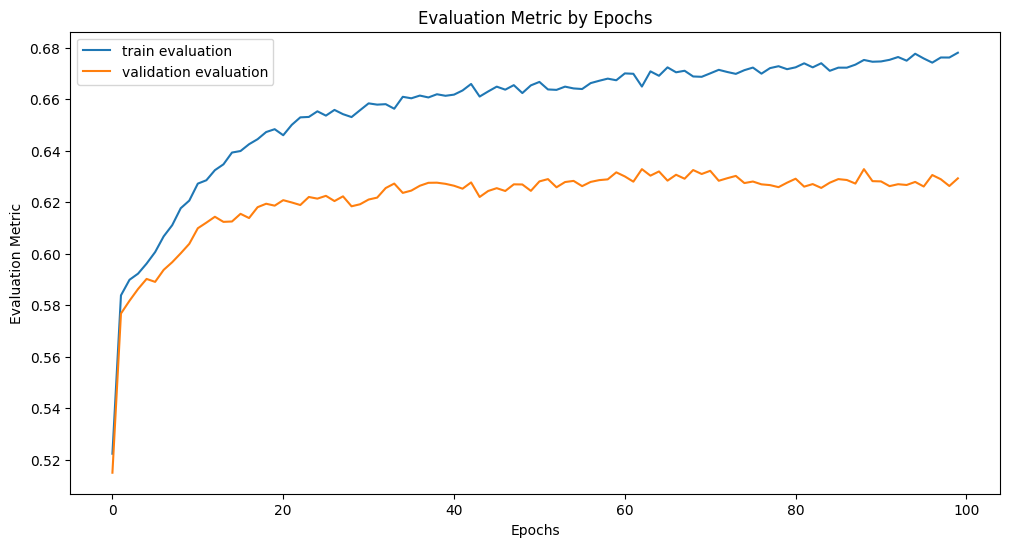

In [67]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced_ap, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [69]:
executor.test(model, test_dataset, evaluator, if_regression = False)

0.627800912155463

# With all BSD features

In [31]:
# load your data here if kodaira symbol has been processed
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_reg.parquet"
df = utils.load_data(path)
df_BSD = df[['rank', 'special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sha']]

Loaded the dataset with 120 features and 3064705 curves..


In [39]:
# to get a balanced dataset with equal amount of 4 and 9 labels
len_9 = df_BSD[df_BSD['sha'] == 9].shape[0]

df_BSD_balanced = df_BSD[df_BSD['sha'] == 4].sample(len_9) 
# df_balanced = df[df['sha'] == 4].iloc[:len_9]

df_BSD_balanced = pd.concat([df_BSD_balanced, df_BSD[df_BSD['sha'] == 9]])

# rename 4 to 0 and 9 to 1
df_BSD_balanced['sha'] = df_BSD_balanced['sha'].replace({4: 0, 9: 1})

## logistic regression

In [40]:
# split the data into training and testing
X = df_BSD_balanced.drop('sha', axis=1)
y = df_BSD_balanced['sha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

model = LogisticRegression()
# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.6573963910370811


## NN

In [41]:
# choose model parameters
# hidden_units = [128,64,32]
# hidden_units = [64,32,16]
hidden_units = [32,16,8]
# hidden_units = [16,8,4]
# hidden_units = [8,4,2]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_BSD_balanced, 'sha', if_regression=False)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=True, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 6 and the output dimension is 2.
Device: cpu.
The model has 1,018 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [42]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 30
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

Epoch 1/30, Training accuracy_score: 0.6983127592418158, Validation accuracy_score: 0.7004114818303505
Epoch 2/30, Training accuracy_score: 0.8685075934096805, Validation accuracy_score: 0.866788954439542
Epoch 3/30, Training accuracy_score: 0.8405797101449275, Validation accuracy_score: 0.8409102176391849
Epoch 4/30, Training accuracy_score: 0.8896765984168691, Validation accuracy_score: 0.889296514798473
Epoch 5/30, Training accuracy_score: 0.8986168261365326, Validation accuracy_score: 0.8982202171434237
Epoch 6/30, Training accuracy_score: 0.8693834382694627, Validation accuracy_score: 0.8673342918050667
Epoch 7/30, Training accuracy_score: 0.9191743922793449, Validation accuracy_score: 0.9158693173367706
Epoch 8/30, Training accuracy_score: 0.881182555814453, Validation accuracy_score: 0.8805215408259383
Epoch 9/30, Training accuracy_score: 0.8873960967064928, Validation accuracy_score: 0.8875117743294829
Epoch 10/30, Training accuracy_score: 0.8828350932857403, Validation accurac

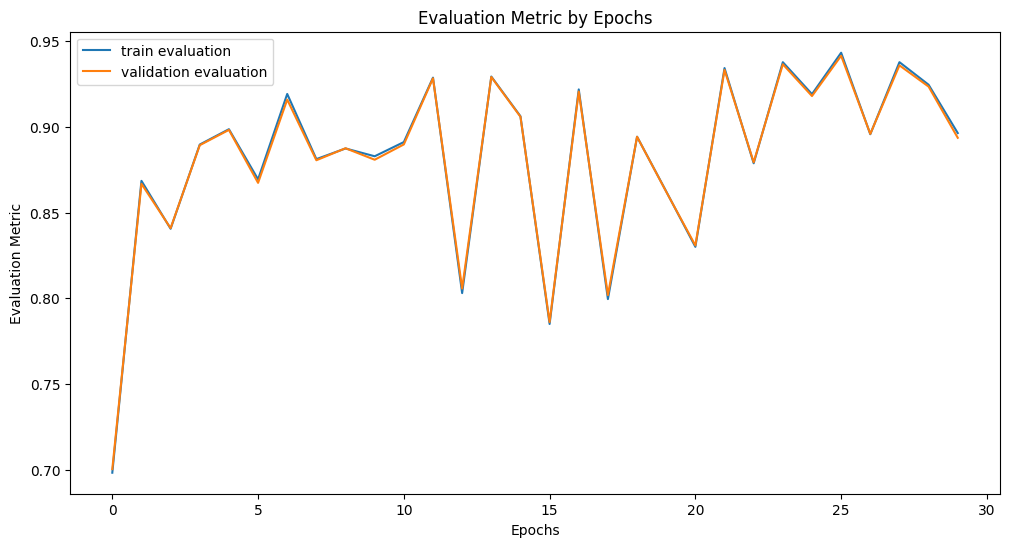

In [43]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_BSD_balanced, 'sha', device, if_regression=False)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [44]:
executor.test(model, test_dataset, evaluator, if_regression = False)

0.9434364465595876

# just load a trained model and see the result

In [ ]:
# # load data
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
# df = utils.load_data(path)

# # load torch model
# import torch
# model = torch.load(Path("..") / "trained_models" / "model.pth")

# # split data
# train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# X_test, y_test = test_dataset.tensors

# # test the model
# model.eval()
# outputs = model(X_test)
# y_pred = outputs.squeeze()

# # get the l1 distance between the predicted and actual values
# loss = torch.nn.L1Loss()
# loss(y_pred, y_test)